## **Weather Forecasting Module**

Fetch daily weather history via the free Open-Meteo API, turn it into a pandas DataFrame, and leave a clean hook for later modeling (AR/MA).

In [1]:
import requests
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt

import numpy as np

DEFAULT_END = date.today()
DEFAULT_START = DEFAULT_END - timedelta(days=548)

## **Data Collection**

In [2]:
def geocode_city(city: str) -> tuple[float, float]:
    """Return (lat, lon) for a city name using Open-Meteo's free geocoding API."""
    url = "https://geocoding-api.open-meteo.com/v1/search"
    resp = requests.get(url, params={"name": city, "count": 1, "language": "en"}, timeout=10)
    resp.raise_for_status()
    data = resp.json()
    results = data.get("results") or []
    if not results:
        raise ValueError(f"No geocoding results for '{city}'")
    lat = results[0]["latitude"]
    lon = results[0]["longitude"]
    return lat, lon


In [3]:
def fetch_weather_timeseries(city: str, start: date | None = None, end: date | None = None) -> pd.DataFrame:
    """
    Fetch daily weather history (avg/min/max temp, precip) for a city into a DataFrame.

    Uses Open-Meteo's archive API. Dates are inclusive and must be in YYYY-MM-DD.
    """
    start = start or DEFAULT_START
    end = end or DEFAULT_END
    
    # Ensure end date is not in the future (API limitation)
    today = date.today()
    if end > today:
        print(f"Warning: end date {end} is in the future. Using today ({today}) instead.")
        end = today
    
    if start > end:
        raise ValueError(f"start date ({start}) must be <= end date ({end})")

    lat, lon = geocode_city(city)

    url = "https://archive-api.open-meteo.com/v1/archive"
    # Open-Meteo API expects daily as a list
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start.isoformat(),
        "end_date": end.isoformat(),
        "daily": ["temperature_2m_max", "temperature_2m_min", "temperature_2m_mean", "precipitation_sum"],
        "timezone": "auto",
    }

    resp = requests.get(url, params=params, timeout=20)
    if resp.status_code != 200:
        print(f"API Error: {resp.status_code}")
        print(f"URL: {resp.url}")
        print(f"Response: {resp.text[:500]}")
    resp.raise_for_status()
    data = resp.json()

    # Build DataFrame safely
    daily = data.get("daily", {})
    df = pd.DataFrame(daily)
    if df.empty:
        raise ValueError("No weather data returned; check dates or API availability")

    df["time"] = pd.to_datetime(df["time"])
    df.set_index("time", inplace=True)
    df.rename(
        columns={
            "temperature_2m_max": "temp_max_c",
            "temperature_2m_min": "temp_min_c",
            "temperature_2m_mean": "temp_mean_c",
            "precipitation_sum": "precip_mm",
        },
        inplace=True,
    )
    return df


In [4]:
# Check if weather_df already exists (data collection already done)
if 'weather_df' in globals() and globals()['weather_df'] is not None:
    weather_df = globals()['weather_df']
    if len(weather_df) > 0:
        print(f"✓ Using existing weather_df with {len(weather_df)} days")
        print(f"Data spans {weather_df.index.min().date()} to {weather_df.index.max().date()}")
        display(weather_df.head())
        display(weather_df.tail(3))
    else:
        print("weather_df exists but is empty. Fetching from API...")
        weather_df = None  # Will trigger fetch below
else:
    print("weather_df not found. Fetching from API...")
    weather_df = None  # Will trigger fetch below

# Fetch data if not available
if weather_df is None:
    print(f"Today's date: {date.today()}")
    print(f"Default date range: {DEFAULT_START} to {DEFAULT_END}")
    
    try:
        weather_df = fetch_weather_timeseries("Dubai")
        display(weather_df.head())
        display(weather_df.tail(3))
        print(f"✓ Fetched {len(weather_df)} days spanning {weather_df.index.min().date()} to {weather_df.index.max().date()}")
    except Exception as exc:
        print(f"✗ Initial fetch failed: {exc}")
        print("\nTrying with a more conservative date range (last 3 years)...")
        try:
            # Try with a shorter, more recent date range
            end_date = date.today() - timedelta(days=1)  # Yesterday
            start_date = end_date - timedelta(days=1095)  # 3 years ago
            print(f"Trying date range: {start_date} to {end_date}")
            weather_df = fetch_weather_timeseries("Dubai", start=start_date, end=end_date)
            display(weather_df.head())
            display(weather_df.tail(3))
            print(f"✓ Fetched {len(weather_df)} days spanning {weather_df.index.min().date()} to {weather_df.index.max().date()}")
        except Exception as exc2:
            print(f"✗ Fallback fetch also failed: {exc2}")
            print("\n" + "="*60)
            print("DATA LOADING INSTRUCTIONS:")
            print("="*60)
            print("Since data collection is already done, please load your data manually.")
            print("\nOption 1: If data is in a CSV file:")
            print("  weather_df = pd.read_csv('your_data.csv', index_col=0, parse_dates=True)")
            print("\nOption 2: If data is in a pickle file:")
            print("  weather_df = pd.read_pickle('your_data.pkl')")
            print("\nOption 3: If data is already in memory from a previous session,")
            print("  just run the cells above that define weather_df.")
            print("="*60)
            raise exc2


weather_df not found. Fetching from API...
Today's date: 2025-12-28
Default date range: 2024-06-28 to 2025-12-28


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2024-06-28,39.3,28.5,34.0,0.0
2024-06-29,41.2,30.2,34.4,0.0
2024-06-30,40.7,28.2,33.9,0.0
2024-07-01,40.0,29.0,34.2,0.0
2024-07-02,43.0,29.0,35.6,0.0


,temp_max_c,temp_min_c,temp_mean_c,precip_mm
time,,,,
2025-12-26,24.3,15.8,19.5,0.0
2025-12-27,25.1,14.6,19.7,0.0
2025-12-28,27.5,15.4,21.7,0.0


✓ Fetched 549 days spanning 2024-06-28 to 2025-12-28


## **Data Exploration and Cleaning**

In [5]:
# Basic structure
print(weather_df.info())
print(weather_df.describe())

# Missing values check
print("\nMissing values per column:")
print(weather_df.isna().sum())

# Quick correlation snapshot
corr = weather_df.corr()
print("\nCorrelation matrix:")
display(corr)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 549 entries, 2024-06-28 to 2025-12-28
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temp_max_c   549 non-null    float64
 1   temp_min_c   549 non-null    float64
 2   temp_mean_c  549 non-null    float64
 3   precip_mm    549 non-null    float64
dtypes: float64(4)
memory usage: 21.4 KB
None
       temp_max_c  temp_min_c  temp_mean_c   precip_mm
count  549.000000  549.000000   549.000000  549.000000
mean    35.696539   23.769945    29.161566    0.101821
std      6.999664    5.989583     6.103027    1.566191
min     20.500000   10.200000    15.600000    0.000000
25%     30.400000   18.500000    23.900000    0.000000
50%     37.300000   25.100000    30.600000    0.000000
75%     41.700000   28.700000    34.400000    0.000000
max     47.900000   34.200000    39.200000   35.500000

Missing values per column:
temp_max_c     0
temp_min_c     0
temp_mean_c    0
preci

,temp_max_c,temp_min_c,temp_mean_c,precip_mm
temp_max_c,1.000000,0.906129,0.972748,-0.115802
temp_min_c,0.906129,1.000000,0.975004,-0.078758
temp_mean_c,0.972748,0.975004,1.000000,-0.092743
precip_mm,-0.115802,-0.078758,-0.092743,1.000000


<Figure size 640x480 with 0 Axes>

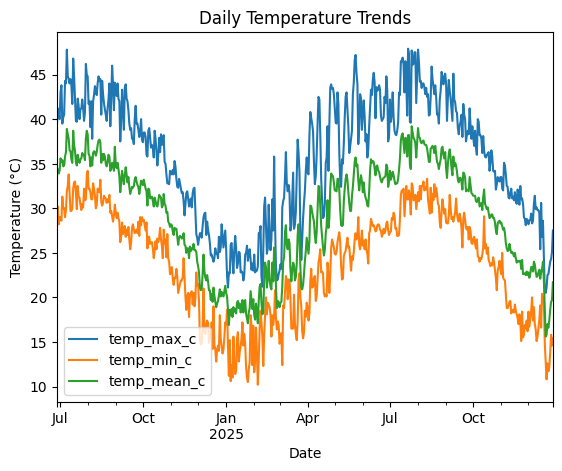

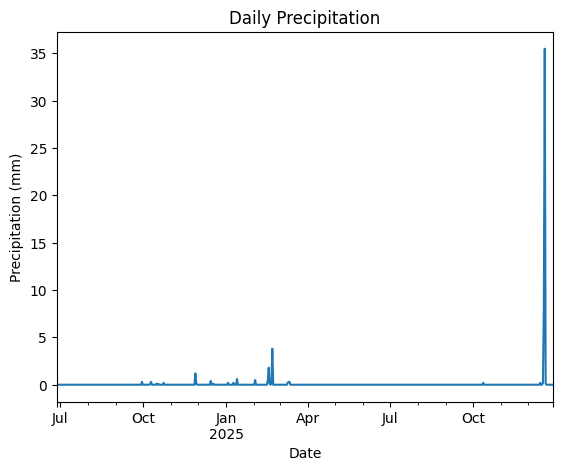

In [6]:
plt.figure()
weather_df[["temp_max_c", "temp_min_c", "temp_mean_c"]].plot()
plt.title("Daily Temperature Trends")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

plt.figure()
weather_df["precip_mm"].plot()
plt.title("Daily Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (mm)")
plt.show()

<Figure size 640x480 with 0 Axes>

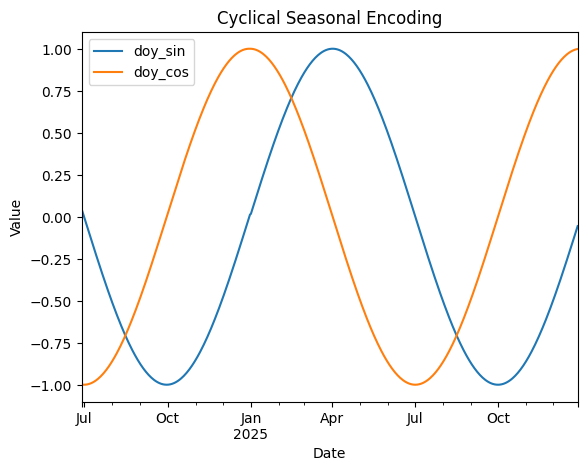

In [7]:
df = weather_df.copy()

df["day_of_year"] = df.index.dayofyear

df["doy_sin"] = np.sin(2 * np.pi * df["day_of_year"] / 365.25)
df["doy_cos"] = np.cos(2 * np.pi * df["day_of_year"] / 365.25)

plt.figure()
df[["doy_sin", "doy_cos"]].plot()
plt.title("Cyclical Seasonal Encoding")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()

### **Dataset Split**

In [8]:
# Ensure datetime index
df.index = pd.to_datetime(df.index)

# Sort by time (important safeguard)
df = df.sort_index()

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

n = len(df)

train_end = int(n * train_ratio)
val_end = train_end + int(n * val_ratio)


train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

assert train_df.index.max() < val_df.index.min()
assert val_df.index.max() < test_df.index.min()

Weather forecasting is a **multi-scale, multi-physics problem**, and the optimal model depends on forecast horizon, data availability, and purpose. What is clear, however, is that different model classes dominate at different levels, and using the wrong one will silently cap your performance no matter how well you tune it

- **Best possible** → Physics-based NWP (unreachable for individuals)
- **Best practical ML** → Gradient Boosting with lag + cyclical features
- **Best interpretable baseline** → SARIMAX
- **Best system-learning model** → VAR / VARMAX
- **Best at scale** → Deep learning (only with big data)



In [9]:
# Configuration Load
def load_config():
    return {
        "targets": ["temp_max_c", "temp_min_c", "temp_mean_c", "precip_mm"],
        "feature_cols": ["temp_max_c", "temp_min_c", "temp_mean_c", "precip_mm"],
        "lags": [1, 7, 14, 30],
        "rolling_windows": [7, 14, 30],
        "metrics": ["mae", "rmse"],
        "season_length": 365,
        "forecast_horizon": 7,
    }

In [10]:
# Feature Engineering

def add_lag_features(df, cols, lags):
    df = df.copy()
    for col in cols:
        for lag in lags:
            df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return df


def add_rolling_features(df, cols, windows):
    df = df.copy()
    for col in cols:
        for w in windows:
            df[f"{col}_roll_mean_{w}"] = df[col].shift(1).rolling(w).mean()
            df[f"{col}_roll_std_{w}"] = df[col].shift(1).rolling(w).std()
    return df

def build_features(df, feature_cols, lags, windows):
    df_feat = add_lag_features(df, feature_cols, lags)
    df_feat = add_rolling_features(df_feat, feature_cols, windows)
    df_feat = df_feat.dropna()
    return df_feat


In [11]:
# Supervised Split
def prepare_xy(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y


In [12]:
# Baselines
def naive_last_value_baseline(y_true):
    y_pred = y_true.shift(1).dropna()
    y_true = y_true.loc[y_pred.index]
    
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    return {"mae": mae, "rmse": rmse}

def seasonal_naive_baseline(y_true, season_length=365):
    y_pred = y_true.shift(season_length).dropna()
    y_true = y_true.loc[y_pred.index]
    
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    return {"mae": mae, "rmse": rmse}


In [ ]:
# Ensemble Method Training
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

def train_gb_model(X_train, y_train, X_val, y_val, params=None):
    if params is None:
        params = {
            "n_estimators": 500,
            "learning_rate": 0.05,
            "max_depth": -1,
            "num_leaves": 31,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "random_state": 42,
            "n_jobs": -1
        }

    model = LGBMRegressor(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="l2",
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=0)
        ]
    )

    return model


In [14]:
# Evaluation and Skill

def evaluate_model(model, X_test, y_test):
    preds = model.predict(X_test)
    
    mae = np.mean(np.abs(y_test - preds))
    rmse = np.sqrt(np.mean((y_test - preds) ** 2))
    
    return {
        "mae": mae,
        "rmse": rmse,
        "predictions": preds
    }

def skill_score(model_error, baseline_error):
    return 1 - (model_error / baseline_error)

In [15]:
# Recursive Forecasting

def recursive_forecast(model, last_known_df, horizon):
    history = last_known_df.copy()
    forecasts = []

    for _ in range(horizon):
        X_next = history.iloc[[-1]].dropna(axis=1)
        y_pred = model.predict(X_next)[0]
        forecasts.append(y_pred)

        next_row = history.iloc[-1].copy()
        next_row[:] = next_row[:]  # keep structure
        next_row["temp_mean_c"] = y_pred  # overwrite target
        history = pd.concat([history, next_row.to_frame().T])

    return pd.Series(forecasts)


In [16]:
# Interpretation

def plot_feature_importance(model, X):
    importance = pd.DataFrame({
        "feature": X.columns,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    importance.head(20).plot(
        x="feature",
        y="importance",
        kind="barh",
        figsize=(8, 6),
        title="Top Feature Importances"
    )

    return importance


In [17]:
cfg = load_config()

train_feat = build_features(train_df, cfg["feature_cols"], cfg["lags"], cfg["rolling_windows"])
val_feat   = build_features(val_df, cfg["feature_cols"], cfg["lags"], cfg["rolling_windows"])
test_feat  = build_features(test_df, cfg["feature_cols"], cfg["lags"], cfg["rolling_windows"])

X_train, y_train = prepare_xy(train_feat, "temp_mean_c")
X_val, y_val     = prepare_xy(val_feat, "temp_mean_c")
X_test, y_test   = prepare_xy(test_feat, "temp_mean_c")

model = train_gb_model(X_train, y_train, X_val, y_val)
results = evaluate_model(model, X_test, y_test)


TypeError: LGBMRegressor.fit() got an unexpected keyword argument 'early_stopping_rounds'